# Lecture: Complex Network Analysis

Prof. Dr. Michael Gertz

Winter Semester 2021/22

## Assignment 7 - Assortativity and Robustness

Students: Felix Hausberger, Nils Krehl, Patrick Günther

# 1. Build graph

In [12]:
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import scipy
import pickle

In [2]:
df_blogs = pd.read_csv('assortativity_networks/blogs.txt', sep="\t", header=None)
df_javax = pd.read_csv('assortativity_networks/javax.txt', delim_whitespace=True, header=None)
df_network_science = pd.read_csv('assortativity_networks/network-science.txt', sep="\t", header=None)

In [3]:
df_blogs

,0,1
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6
...,...,...
33425,975,664
33426,975,67
33427,975,1004
33428,975,1224


In [4]:
# since it is an undirected graph, no parallel edges are added
G_blogs = nx.Graph()
G_blogs.add_edges_from(df_blogs.itertuples(index=False))

G_javax = nx.Graph()
G_javax.add_edges_from(df_javax.itertuples(index=False))

G_network_science = nx.Graph()
G_network_science.add_edges_from(df_network_science.itertuples(index=False))

# remove self-loops
G_blogs.remove_edges_from(nx.selfloop_edges(G_blogs))
G_javax.remove_edges_from(nx.selfloop_edges(G_javax))
G_network_science.remove_edges_from(nx.selfloop_edges(G_network_science))

In [5]:
print(f"Number of nodes in blogs is {G_blogs.number_of_nodes()}.")
print(f"Number of edges in blogs is {G_blogs.number_of_edges()}.")
print()
print(f"Number of nodes in javax is {G_javax.number_of_nodes()}.")
print(f"Number of edges in javax is {G_javax.number_of_edges()}.")
print()
print(f"Number of nodes in network-science is {G_network_science.number_of_nodes()}.")
print(f"Number of edges in network-science is {G_network_science.number_of_edges()}.")

Number of nodes in blogs is 1224.
Number of edges in blogs is 16715.

Number of nodes in javax is 6120.
Number of edges in javax is 50290.

Number of nodes in network-science is 1461.
Number of edges in network-science is 2742.


# 2. Degree correlation matrix

In [6]:
def calculate_degree_correlation_matrix(G):
    max_degree = max(deg for n, deg in G.degree)
    # create a dict to save the number of degree combinations
    degrees = []
    for i in range(max_degree+1):
        for j in range(max_degree+1):
            degrees.append((i,j))

    deg_1 = []
    deg_2 = []
    for i in degrees:
        deg_1.append(i[0])
        deg_2.append(i[1])
    d = {'deg_1': deg_1, 'deg_2': deg_2, 'count': 0}
    degree_correlation_df = pd.DataFrame(data=d)

    for u,v,weight in G.edges(data=True):
        degree_correlation_df.loc[degree_correlation_df.eval(f'deg_1 == {G.degree(u)} & deg_2 == {G.degree(v)}'), 'count'] += 1
    
    deg_corr_mat = np.zeros((max_degree+1, max_degree+1))
    for index, row in degree_correlation_df.iterrows():
        deg_corr_mat[row['deg_1'], row['deg_2']] = row['count']

    deg_corr_mat = deg_corr_mat + deg_corr_mat.T
    deg_corr_mat_prob = deg_corr_mat / np.sum(deg_corr_mat)
    
    deg_corr_mat_absolute = deg_corr_mat
    
    return deg_corr_mat_absolute, deg_corr_mat_prob

In [7]:
deg_corr_mat_blogs_absolute, deg_corr_mat_blogs = calculate_degree_correlation_matrix(G_blogs)

In [8]:
deg_corr_mat_network_science_absolute, deg_corr_mat_network_science = calculate_degree_correlation_matrix(G_network_science)

In [13]:
# deg_corr_mat_javax_absolute, deg_corr_mat_javax = calculate_degree_correlation_matrix(G_javax)
with open(r"deg_corr_mat_javax_absolute.pkl", "rb") as input_file:
    deg_corr_mat_javax_absolute = pickle.load(input_file)
    
with open(r"deg_corr_mat_javax.pkl", "rb") as input_file:
    deg_corr_mat_javax = pickle.load(input_file)

# 3. Heatmap

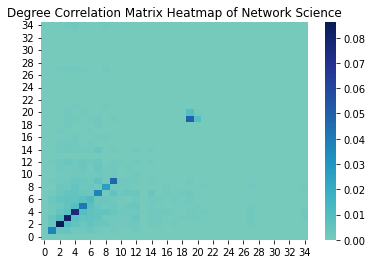

In [17]:
ax = sns.heatmap(deg_corr_mat_network_science, cmap="YlGnBu", center=0.015)
ax.invert_yaxis()
plt.title("Degree Correlation Matrix Heatmap of Network Science")
plt.show()

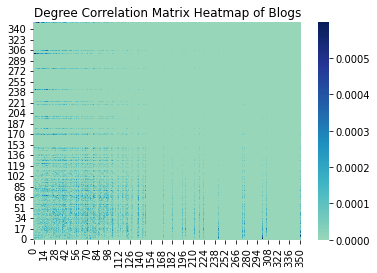

In [18]:
ax = sns.heatmap(deg_corr_mat_blogs, cmap="YlGnBu", center=0.00015)
ax.invert_yaxis()
plt.title("Degree Correlation Matrix Heatmap of Blogs")
plt.show()

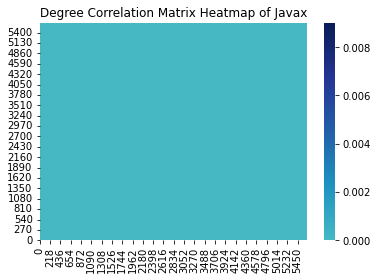

In [19]:
ax = sns.heatmap(deg_corr_mat_javax, cmap="YlGnBu", center=0.00015)
ax.invert_yaxis()
plt.title("Degree Correlation Matrix Heatmap of Javax")
plt.show()

The degree correlation matrix makes most sense for analysis when used on networks with smaller maximum degree (or lower number of different degrees) like Network Science. The bins of Javax are so small that no real information can be obtained. 
For Network Science the heat map indicates that it is an assortative network.
For Blogs it is hard to determine assortativity of the network, since the degree correlation does not follow the known scheme from the lecture. Lower degree nodes seem to be connected mostly to lower degree nodes, but high degree nodes seem mostly also connected to low degree nodes.

# 4. Nearest neighbor degree

In [12]:
# calculates nearest neighbor degree for singe nodes
def calculate_k_nn_single_node(G, node):
    neighbors = list(G.neighbors(node))
    return np.sum([G.degree(neighbor) for neighbor in neighbors]) / G.degree(node)

In [13]:
# get k_i
degrees_network_science = [G_network_science.degree(node) for node in G_network_science.nodes]
k_i_network_science = []
for node in list(G_network_science.nodes):
    k_i_network_science.append(calculate_k_nn_single_node(G_network_science, node))

degrees_blogs = [G_blogs.degree(node) for node in G_blogs.nodes]
k_i_blogs = []
for node in list(G_blogs.nodes):
    k_i_blogs.append(calculate_k_nn_single_node(G_blogs, node))
    
k_i_javax = []
degrees_javax = [G_javax.degree(node) for node in G_javax.nodes]
for node in list(G_javax.nodes):
    k_i_javax.append(calculate_k_nn_single_node(G_javax, node))


In [14]:
# calculates nearest neighbor degree for all nodes of degree k
def calculate_k_nn(k, deg_corr_mat_absolute):
    neighbors = deg_corr_mat_absolute[k]
    num_neighbors = np.sum(neighbors)
    
    return np.sum([k_prime * neighbors[k_prime] / num_neighbors for k_prime in range(len(neighbors))])

In [15]:
# get k_nn
k_nn_network_science = []
for k in range(len(deg_corr_mat_network_science_absolute[0])):
    k_nn_network_science.append(calculate_k_nn(k, deg_corr_mat_network_science_absolute))
    
k_nn_blogs = []
for k in range(len(deg_corr_mat_blogs_absolute[0])):
    k_nn_blogs.append(calculate_k_nn(k, deg_corr_mat_blogs_absolute))

k_nn_javax = []
for k in range(len(deg_corr_mat_javax_absolute[0])):
    k_nn_javax.append(calculate_k_nn(k, deg_corr_mat_javax_absolute))

/opt/anaconda3/envs/complexnetworkanalysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


# Scatter plot

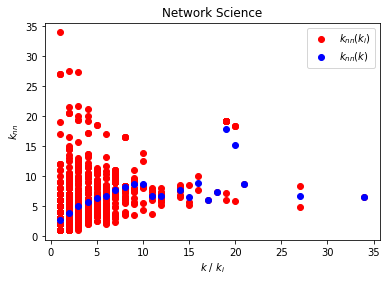

In [16]:
plt.scatter(degrees_network_science, k_i_network_science, c='red', label='$k_{nn}(k_i)$')
plt.scatter(range(len(deg_corr_mat_network_science_absolute[0])), k_nn_network_science, c='blue', label='$k_{nn}(k)$')
plt.title("Network Science")
plt.xlabel('$k$ / $k_i$')
plt.ylabel('$k_{nn}$')
plt.legend()
plt.show()

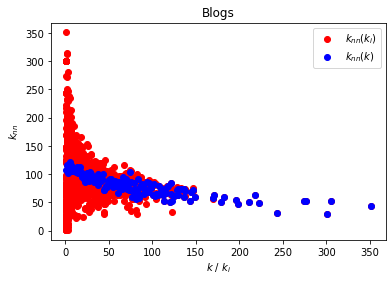

In [17]:
plt.scatter(degrees_blogs, k_i_blogs, c='red', label='$k_{nn}(k_i)$')
plt.scatter(range(len(deg_corr_mat_blogs_absolute[0])), k_nn_blogs, c='blue', label='$k_{nn}(k)$')
plt.title("Blogs")
plt.xlabel('$k$ / $k_i$')
plt.ylabel('$k_{nn}$')
plt.legend()
plt.show()

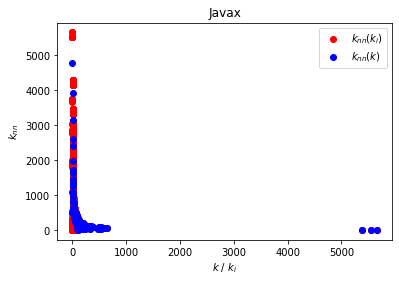

In [18]:
plt.scatter(degrees_javax, k_i_javax, c='red', label='$k_{nn}(k_i)$')
plt.scatter(range(len(deg_corr_mat_javax_absolute[0])), k_nn_javax, c='blue', label='$k_{nn}(k)$')
plt.title("Javax")
plt.xlabel('$k$ / $k_i$')
plt.ylabel('$k_{nn}$')
plt.legend()
plt.show()

In Network Science, nodes with lower degree tend to have neighbors with low average degree, and higher degree nodes tend to have neighbors with high average degree. This supports the idea that Network Science is assortative.
The opposite is true for Blogs, which seems to be a disassortative network.
Javax seems also to be disassortative and has the interesting property, that it has few really high degree nodes. The neighbors of these hubs only have a low average degree.

# Degree correlation coefficient

In [19]:
def compute_degree_correlation_coefficient(G, deg_corr_mat):
    max_degree = max(deg for n, deg in G.degree)
    
    avg_degree = sum(deg for n, deg in G.degree)/len(G.degree)

    q_k = {}
    for deg in range(max_degree + 1):
        p_k = [deg for n, deg in G.degree].count(deg)/len(G.degree)
        q_k[deg] = (deg * p_k)/avg_degree
        
    sigma_squared = sum([(k**2) * q_k[k] for k in q_k]) - sum([k * q_k[k] for k in q_k])**2

    r = []

    for j, row in enumerate(deg_corr_mat):
        for k, e_jk in enumerate(row):
            qk = q_k[k]
            qj = q_k[j]
            r.append((j*k*(e_jk-qj*qk))/sigma_squared)

    r = sum(r)
    
    return r

In [20]:
print(f"The degree correlation coefficient with our computation for Network Science is r={compute_degree_correlation_coefficient(G_network_science, deg_corr_mat_network_science)}")
# to check our computation, we also use the inbuild function of networkx
print(f"The degree correlation coefficient with the inbuild networkx function for Network Science is r={nx.algorithms.assortativity.degree_assortativity_coefficient(G_network_science)}")

The degree correlation coefficient with our computation for Network Science is r=0.4616224667525837
The degree correlation coefficient with the inbuild networkx function for Network Science is r=0.4616224667525835


In [21]:
print(f"The degree correlation coefficient with our computation for Blogs is r={compute_degree_correlation_coefficient(G_blogs, deg_corr_mat_blogs)}")
# to check our computation, we also use the inbuild function of networkx
print(f"The degree correlation coefficient with the inbuild networkx function for Blogs is r={nx.algorithms.assortativity.degree_assortativity_coefficient(G_blogs)}")

The degree correlation coefficient with our computation for Blogs is r=-0.2212328638045546
The degree correlation coefficient with the inbuild networkx function for Blogs is r=-0.22123286380455423


In [26]:
print(f"The degree correlation coefficient with our computation for Javax is r={compute_degree_correlation_coefficient(G_javax, deg_corr_mat_javax)}")
# to check our computation, we also use the inbuild function of networkx
print(f"The degree correlation coefficient with the inbuild networkx function for Javax is r={nx.algorithms.assortativity.degree_assortativity_coefficient(G_javax)}")

The degree correlation coefficient with our computation for Javax is r=-0.2327051928360141
The degree correlation coefficient with the inbuild networkx function for Javax is r=-0.23270519283601443


From analysing the degree correlation coefficients, based on the rules on slide 7-16 we can say:

Network Science is assortative.

Blogs is disassortative.

Javax is disassortative.

# because it took forever: pickle stuff
with open('deg_corr_mat_javax_absolute.pkl','wb') as f:
    pickle.dump(deg_corr_mat_javax_absolute, f)
    
with open('deg_corr_mat_javax.pkl','wb') as f:
    pickle.dump(deg_corr_mat_javax, f)

#  Discuss the advantages and disadvantages of each method

As already discussed, the heatmap plot of the degree correlation matrix can give a indication of assortativity for some network. this is the case if the distribution of degree correlations is somewhat clear. Also it is only useful on networks with not to high degrees (or a low number of unique degrees). If this is not the case, the probabilities of each combination (bins) are getting to low to get meaningful insights, or the shape of the heatmap does not give clear indications. 
The plot of the nearest neighbor degrees gives clearer inside and more meaningful results. From this, the assortativity of the networks was clearly visible. Also, it gives insights on the overall distribution of the average degrees. 
The degree correlation coefficient gave the clearest result for assortativity, having clear thresholds. On the downside, being only a number, detailed information about the overall distribution of degrees gets lost.